In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [23]:
class DynamicMovementPrimitives():
    
    def __init__(self,trajectory,time, duration,data_length,BF_number,x0,g,weights):
        self.convergence_rate = 0.001
        self.alpha = -np.log(self.convergence_rate)
        self.des_tau = duration
        self.data_length = data_length
        self.dt = duration/data_length
        self.BF_number = BF_number
        self.c = np.logspace(-3,0,num=self.BF_number ) # centers of basis functions
        self.h = self.BF_number/ (self.c**2)                # widths of basis functions
        self.K=1000
        self.D=2*np.sqrt(self.K)
        self.weights = weights
        self.x0 = x0
        self.g = g
        self.time = time
        self.trajectory = trajectory
        

    def gaussianEquation(self,s):
        gaussian = -np.exp(-self.h*np.square(s-self.c))
        return gaussian
    
    def calculateNonlinearFuction(self,gaussian,weights,s):
        nominator = np.sum(gaussian*weights.T)
        nominator = nominator*s
        denominator = np.sum(gaussian)
        nonlinearFunction = nominator / denominator
        return nonlinearFunction 
        
    def calculateTransformationSystem(self,velocity,position,nonlinearFunction):
        pdController = self.K*(self.g - position) - self.D*velocity
        nonlinearPertubation = (self.g-self.x0)*nonlinearFunction
        transformationSystem = pdController + nonlinearPertubation
        return transformationSystem
    
    def calculateTransformationSystemImproved(self,velocity,position,nonlinearFunction,s):
        pdController = self.K*(self.g - position) - self.D*velocity
        improvement = self.K*(self.g-self.x0)*s
        nonlinearPertubation = self.K*nonlinearFunction
        transformationSystem = pdController + improvement + nonlinearPertubation 
        return transformationSystem   
    
    def scalePositionByTau(self,derivativeOfTrajectory):
        scaledByTau = derivativeOfTrajectory*self.des_tau 
        return scaledByTau
        
    def takeDerivativeOfTrajectory(self,positionOfTrajectory_x):
        flattened_trajectory_diff = np.diff(positionOfTrajectory_x.flatten())
        flattened_time_diff = np.diff(self.time.flatten())
        flattened_derivative = flattened_trajectory_diff /flattened_time_diff
        flattened_derivative = np.insert(flattened_derivative, 0, flattened_derivative[0])
        derivative = flattened_derivative.reshape(flattened_derivative.shape[0],1)
        return derivative
    
    def calculatePhaseVariableS(self,t):
        s  = np.exp(((-self.alpha/self.des_tau)*t))
        return s

    def calculateAngularVelocity(self,velocityOfTrajectory):
        flattened_velocity_diff = np.diff(velocityOfTrajectory.flatten())
        flattened_time_diff = np.diff(self.time.flatten())
        flattened_derivative = flattened_velocity_diff /flattened_time_diff
        flattened_derivative = np.insert(flattened_derivative, 0, flattened_derivative[0])
        derivative = flattened_derivative.reshape(flattened_derivative.shape[0],1)
        return derivative
    
    def calculateFTarget(self,positionOfTrajectory_x,velocityOfTrajectory_v,angularVelocityOfTrajectory_vdot):
        g_arranged = np.full((positionOfTrajectory_x.shape[0], positionOfTrajectory_x.shape[1]), self.g)
        x0_arranged = np.full((positionOfTrajectory_x.shape[0], positionOfTrajectory_x.shape[1]), self.x0)
        nominator = -1*self.K*(g_arranged-positionOfTrajectory_x) + self.D*velocityOfTrajectory_v + self.des_tau*angularVelocityOfTrajectory_vdot
        denominator = self.g-self.x0
        ftarget = nominator / denominator
        return ftarget

    def calculateError(self, ftarget, fs):
        error = np.sum(np.square(ftarget-fs))
        return error
        
    def linearRegression(self,ftarget,gaussians,phaseVariables_s):
        y = []
        for i in range(ftarget.shape[0]):
            y.append (ftarget[i]*np.sum(gaussians[i]) / phaseVariables_s[i])
        y = np.array(y)
        y = y.reshape(ftarget.shape[0],1)
        w_hat = np.dot(np.linalg.inv(np.dot(np.transpose(gaussians),gaussians)),(np.dot(np.transpose(gaussians),y)))
        return w_hat
    
    
    def findWeights(self):
        positionOfTrajectory_x = self.trajectory
        derivativeOfTrajectory = self.takeDerivativeOfTrajectory(positionOfTrajectory_x)
        velocityOfTrajectory_v = self.scalePositionByTau(derivativeOfTrajectory)
        angularVelocityOfTrajectory_vdot = self.calculateAngularVelocity(velocityOfTrajectory_v)
        ftarget = self.calculateFTarget(positionOfTrajectory_x,velocityOfTrajectory_v,angularVelocityOfTrajectory_vdot)
        phaseVariables_s = self.calculatePhaseVariableS(self.time)
        gaussians = self.gaussianEquation(phaseVariables_s)
        self.weights = self.linearRegression(ftarget,gaussians,phaseVariables_s)
        return self.weights
    
    def plot(self,pos,label1,label2):
        plt.plot(pos)
        plt.ylabel(label1)
        plt.xlabel(label2)
        plt.show()       

    def runDMPImproved(self,perturbation = False, obstacleTime = 0, obsPosition = 0.0):
        s_stack = 0
        nonlinearfunction_stack = 0
        time = 0
        x = self.x0
        x_dot = 0
        position_stack = 0
        time_step = 0
        while time <= self.des_tau:
            #calculating and storing phase variable s for t
            s = self.calculatePhaseVariableS(time)
            s_stack = np.row_stack((s_stack,s))

            #calculate gaussian 
            gaussian = self.gaussianEquation(s)
            
            #calculate nonlinear function and store function value
            nonlinearfunction = self.calculateNonlinearFuction(gaussian,self.weights,s)
            nonlinearfunction_stack = np.row_stack((nonlinearfunction_stack,nonlinearfunction))
            
            #calculate velocity
            velocity = self.des_tau*x_dot
            
            #calculate angular velocity v_dot
            v_dot = self.calculateTransformationSystemImproved(velocity,x,nonlinearfunction,s) / self.des_tau
            
            #update velocity and position
            velocity = velocity + v_dot * self.dt
            x_dot = velocity / self.des_tau
            if perturbation and time_step ==obstacleTime:

                x = obsPosition
            else:
                x = x + x_dot * self.dt
            position_stack = np.row_stack((position_stack,x))
            
            time += self.dt
            time_step += 1
        
        position_stack = np.delete(position_stack, 0)
        return position_stack
        #self.plot(position_stack,"position","time")       
    
    def runDMP(self,perturbation = False, obstacleTime = 0, obsPosition = 0.0):
        s_stack = 0
        nonlinearfunction_stack = 0
        time = 0
        x = self.x0
        x_dot = 0
        position_stack = 0
        time_step = 0
        while time <= self.des_tau:
            #calculating and storing phase variable s for t
            s = self.calculatePhaseVariableS(time)
            s_stack = np.row_stack((s_stack,s))

            #calculate gaussian 
            gaussian = self.gaussianEquation(s)
            
            #calculate nonlinear function and store function value
            nonlinearfunction = self.calculateNonlinearFuction(gaussian,self.weights,s)
            nonlinearfunction_stack = np.row_stack((nonlinearfunction_stack,nonlinearfunction))
            
            #calculate velocity
            velocity = self.des_tau*x_dot
            
            #calculate angular velocity v_dot
            v_dot = self.calculateTransformationSystem(velocity,x,nonlinearfunction) / self.des_tau
            
            #update velocity and position
            velocity = velocity + v_dot * self.dt
            x_dot = velocity / self.des_tau
            if perturbation and time_step ==obstacleTime:
                x = obsPosition
            else:
                x = x + x_dot * self.dt
            position_stack = np.row_stack((position_stack,x))
            
            time += self.dt
            time_step += 1
        
        position_stack = np.delete(position_stack, 0)
        return position_stack
        #self.plot(position_stack,"position","time")
        
        

        


        
    

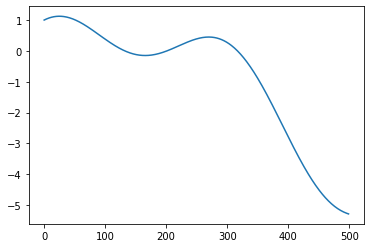

In [24]:
data_length = 500
duration = 10.0
time = np.reshape(np.linspace(0, duration, num = data_length) ,
(data_length,1) )
a = np.cos(time)
b = -0.003*(time**3) -0.005*(time**2) +0.001*time
z = np.sin(0.5*time)+ a + b

plt.plot(z)


In [57]:
def plot(pos,label1,label2,title1,twoData = False,data2=[],labels=[]):
    fig = plt.figure()
    
    if twoData:
        plt.plot(data2, label=labels[0])
        plt.plot(pos, label=labels[1])
        plt.legend()
    else:
        plt.plot(pos)
    fig.suptitle(title1, fontsize=10)
    plt.xlabel(label2, fontsize=8)
    plt.ylabel(label1, fontsize=8)
    figname = title1 + ".jpg"
    fig.savefig(figname) 

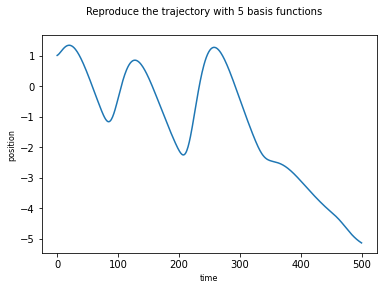

In [58]:
#reproduce the trajectory with 5 basis functions.
dmp1 = DynamicMovementPrimitives(z,time,duration,data_length,5,z[0],z[-1],np.random.rand(5,1))
weights1 =dmp1.findWeights()
position_stack1_0 =dmp1.runDMP()
plot(position_stack1_0,"position","time","Reproduce the trajectory with 5 basis functions")




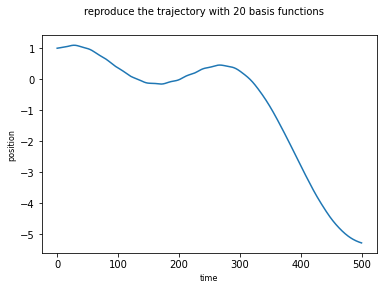

In [59]:
#reproduce the trajectory with 20 basis functions.
dmp2 = DynamicMovementPrimitives(z,time,duration,data_length,20,z[0],z[-1],np.random.rand(20,1))
weights2 =dmp2.findWeights()
position_stack2_0 =dmp2.runDMP()
plot(position_stack2_0,"position","time","reproduce the trajectory with 20 basis functions")


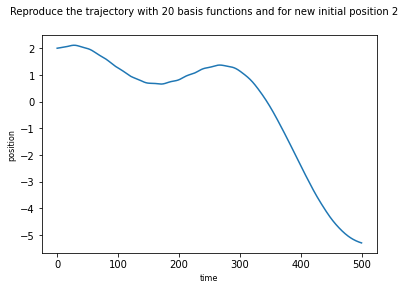

In [60]:
#reproduce the trajectory with 20 basis functions and for new initial position 2
dmp3 = DynamicMovementPrimitives(z,time,duration,data_length,20,2,z[-1],weights2.reshape(20,1))

position_stack3_0 =dmp3.runDMP()
plot(position_stack3_0,"position","time","Reproduce the trajectory with 20 basis functions and for new initial position 2")

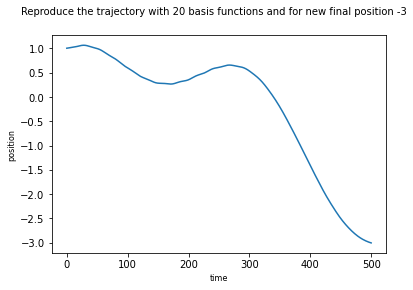

In [61]:
#reproduce the trajectory with 20 basis functions and for new final position -3
dmp4 = DynamicMovementPrimitives(z,time,duration,data_length,20,z[0],-3,weights2.reshape(20,1))

position_stack4_0 =dmp4.runDMP()
plot(position_stack4_0,"position","time","Reproduce the trajectory with 20 basis functions and for new final position -3")

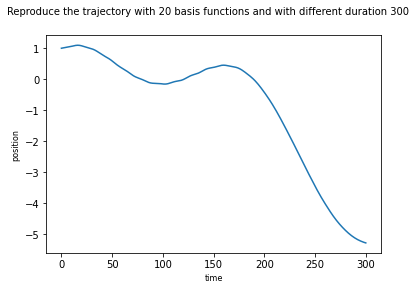

In [62]:
#reproduce the trajectory with 20 basis functions and with different duration 300
dmp5 = DynamicMovementPrimitives(z,time,duration,300,20,z[0],z[-1],weights2.reshape(20,1))
weights2 =dmp5.findWeights()
position_stack5_0 =dmp5.runDMP()
plot(position_stack5_0,"position","time","Reproduce the trajectory with 20 basis functions and with different duration 300")

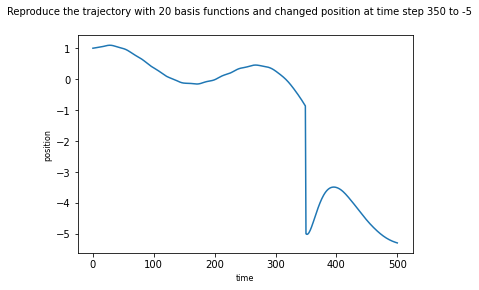

In [63]:
#reproduce the trajectory with 20 basis functions and changed position at time step 350 to -5
dmp6 = DynamicMovementPrimitives(z,time,duration,data_length,20,z[0],z[-1],weights2.reshape(20,1))
position_stack6_0 =dmp6.runDMP(True,350, -5)
plot(position_stack6_0,"position","time","Reproduce the trajectory with 20 basis functions and changed position at time step 350 to -5")

In [ ]:
plot(position_stack1_0,"position","time")
plot(position_stack2_0,"position","time")
plot(position_stack3_0,"position","time")
plot(position_stack4_0,"position","time")
plot(position_stack5_0,"position","time")
plot(position_stack6_0,"position","time")

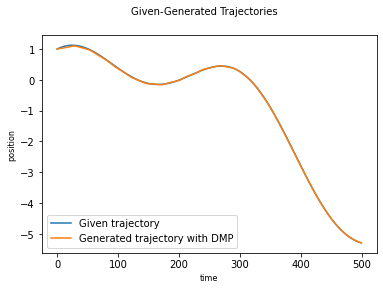

In [64]:
plot(position_stack2_0,"position","time","Given-Generated Trajectories",True,z,["Given trajectory","Generated trajectory with DMP"])


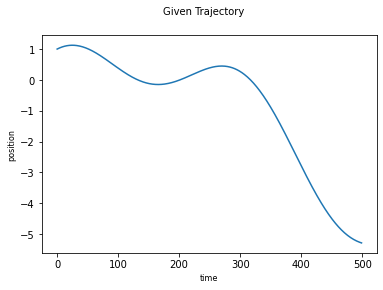

In [65]:
plot(z,"position","time","Given Trajectory")

